In [1]:
import numpy as np
from FRCfuncs import *
import numpy.fft as ft
import matplotlib.pyplot as plt
from sys import float_info
import os
from scipy.optimize import curve_fit
import ctypes
from ctypes import *
import time

In [2]:
def perform_FRC(fftA, fftB, h, w, theta):
    #int cast floors values
    xc = int(w / 2)
    yc = int(h / 2)
    rMax = min(w - xc, h - yc)
    #init return values
    smallAngles = np.zeros(rMax)
    largeAngles = np.zeros(rMax)
    threeSigma = np.zeros(rMax)
    fiveSigma = np.zeros (rMax)
    
    #init local vars
    corr_largeAngles = np.zeros(rMax, dtype = 'complex128')
    absA_largeAngles = np.zeros(rMax)
    absB_largeAngles = np.zeros(rMax)
    corr_smallAngles = np.zeros(rMax, dtype = 'complex128')
    absA_smallAngles = np.zeros(rMax)
    absB_smallAngles = np.zeros(rMax)
    
    #loop over all pixels and update local vars
    for x in range(w):
        for y in range(h):
            #r is the ring number that the pixel is in
            r =  int(round(np.sqrt((x-xc)**2+(y-yc)**2)))
            #we include only full rings in the image, no truncated rings
            if (r < rMax):
                threeSigma[r] += 1
                fiveSigma[r] += 1
               # print("value of theta is %f" %theta)
             #   print("angle of data point equals: %f" % np.arctan(abs(y-yc)/ (abs(x - xc) + float_info.epsilon)))
                if (theta == 0 or np.arctan(abs(y-yc)/ (abs(x - xc) + float_info.epsilon)) > theta ):
                    corr_largeAngles[r] += fftA[y, x] * np.conj(fftB[y, x])
                    absA_largeAngles[r] += abs(fftA[y,x]**2)
                    absB_largeAngles[r] += abs(fftB[y,x]**2)
                else:
                    corr_smallAngles[r] += fftA[y, x] * np.conj(fftB[y, x])
                    absA_smallAngles[r] += abs(fftA[y,x]**2)
                    absB_smallAngles[r] += abs(fftB[y,x]**2)
    
    #compute class vars
    largeAngles = abs(corr_largeAngles) / np.sqrt(absA_largeAngles*absB_largeAngles + float_info.epsilon)
    smallAngles = abs(corr_smallAngles) / np.sqrt(absA_smallAngles*absB_smallAngles + float_info.epsilon)
    threeSigma = 3 / np.sqrt(threeSigma / 2)
    fiveSigma = 5 / np.sqrt(fiveSigma / 2)
    
    #set values higher than 1 to 1.
    for i in range(rMax):
        if (threeSigma[i] > 1):
            threeSigma[i] = 1
        if (fiveSigma[i] > 1):
            fiveSigma[i] = 1

    return smallAngles, largeAngles, threeSigma, fiveSigma

def FRCAnalysis(imA, imB, pixelSize, theta = 0, meanFilterwidth = 3, title = 'someTitle', correctDrift = True):
    checkArguments(imA, imB, theta)
    (w,h) = imA.shape
    hamming = Hamming(w,h)
    fftA = ft.fftshift(ft.fft2(imA*hamming))
    fftB = ft.fftshift(ft.fft2(imB*hamming))
    
    if correctDrift:
        #detect drift of imB
        drift, _ = DriftDetect(imA, imB, pixelSize)
        #correct drift
        fftB = fftShift(fftB, drift)
        print("applied drift correction of %f nm in x and and %f nm in y.\n" 
              % (drift[0] * pixelSize, drift[1] * pixelSize))
        
    smallAngles, largeAngles, threeSigma, fiveSigma = perform_FRC(fftA, fftB, h, w, theta)
    sSmallAngles = meanFilter(smallAngles, meanFilterwidth)
    sLargeAngles = meanFilter(largeAngles, meanFilterwidth)
    pltFRC(pixelSize, title, threeSigma, fiveSigma, sLargeAngles, sSmallAngles)
    
    LargeAnglesResolution = np.ones([3,2]) * -1
    smallAnglesResolution = np.ones([3,2]) * -1
    fixedthreshold = np.ones(smallAngles.shape[0])/7.
    
    LargeAnglesResolution[0] = findIntercept(sLargeAngles, fixedthreshold, pixelSize)
    LargeAnglesResolution[1] = findIntercept(sLargeAngles, threeSigma, pixelSize)
    LargeAnglesResolution[2] = findIntercept(sLargeAngles, fiveSigma, pixelSize)
    
    smallAnglesResolution[0] = findIntercept(sSmallAngles, fixedthreshold, pixelSize)
    smallAnglesResolution[1] = findIntercept(sSmallAngles, threeSigma, pixelSize)
    smallAnglesResolution[2] = findIntercept(sSmallAngles, fiveSigma, pixelSize)
    
    print("retrieved resolution for " + title + " is: " + f"{LargeAnglesResolution[0,0]:.0f}nm\n" )
    
    return sSmallAngles, sLargeAngles, threeSigma, fiveSigma, smallAnglesResolution, LargeAnglesResolution

In [3]:
t0 = time.time()
wdir = r'N:\Singlem\singlem19-1\March\06_FRC_20nmCrimson_NV'
powers = np.arange(0,9,10)
#Data will be stored in a list. Each entry of list contains 3D image of type numpy array.
imStackLst = []
for power in powers:
    ext = r'STEDPowerSeries\{0:d}pct_imA_tac26-200\Red Photons\Frames_    0-    0.txt'.format(power)
    filedirA = os.path.join(wdir, ext)
    ext = r'STEDPowerSeries\{0:d}pct_imB_tac26-200\Red Photons\Frames_    0-    0.txt'.format(power)
    filedirB = os.path.join(wdir, ext)
    imA, imB = readtxt(filedirA, filedirB)
    imStackLst.append ([imA, imB])
t1 = time.time()
print ("computational time equals: " + str( t1 - t0))

computational time equals: 0.739983320236206


applied drift correction of 0.335774 nm in x and and 6.414239 nm in y.



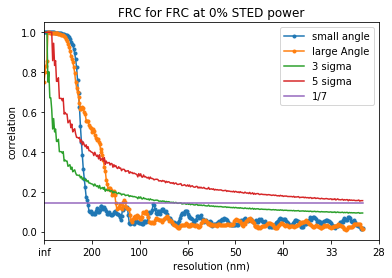

retrieved resolution for FRC at 0% STED power is: 132nm

small angle resolution is 217.826087


NameError: name 'res' is not defined

In [11]:
Nimg = len(powers)
FRC = np.zeros(Nimg)
sFRC = np.zeros(Nimg)
Bleaching = np.zeros(Nimg)
BleachingSigma = np.zeros(Nimg)
for i, imStack in enumerate(imStackLst):
    power = powers[i]
    imA = imStack[0]
    imB = imStack[1]
    smallAngles, largeAngles, __, __, sres, lres = FRCAnalysis(imA, imB, 15, theta = 0.5, title = "FRC at " + str(power) + "% STED power")

    print("small angle resolution is %f" % sres[0,0])

## c-wrapper for Gaussian Fit

In [13]:
c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer

class OptsCluster(ctypes.Structure):
    _fields_ = [
        ("threshold", ctypes.c_int),
        ("relative_thr", ctypes.c_char),
        ("offset", ctypes.c_int),
        ("maxNPeaks", ctypes.c_int),
        ("fit2DGauss", ctypes.c_char),
        ("sigma0", ctypes.c_double),
        ("dsigma_max", ctypes.c_double),
        ("must_converge", ctypes.c_char),
        ("max_threshold", ctypes.c_int)]
    
options = OptsCluster(1, 0, 1, 1, 0, 2, 5, 1, 100)
    
class ResultsCluster(ctypes.Structure):
    _fields_ = [
        ("imageID", ctypes.c_uint),
        ("pixelID", ctypes.c_uint),
        ("peak_x", ctypes.c_double),
        ("peak_y", ctypes.c_double),
        ("intensity", ctypes.c_double),
        ("chi2", ctypes.c_double),
        ("lm_message", ctypes.c_int),
        ("std", ctypes.c_double),
        ("sigma_x", ctypes.c_double),
        ("sigma_y", ctypes.c_double),
        ("backgroud", ctypes.c_double),
        ("max_x", ctypes.c_double),
        ("max_y", ctypes.c_double),
        ("Ncounts", ctypes.c_double)]
results = ResultsCluster(0,0,10,10,10,1,0,1,2,2,1,10,10,50)

    
syntheticGauss_p = syntheticGauss.ctypes.data_as(c_int_p)
size_x = ctypes.c_int(box)
size_y = ctypes.c_int(box)
Nimage = ctypes.c_int(0)
Nall = ctypes.c_int(0)
Ngood = ctypes.c_int(0)
Nconverged = ctypes.c_int(0)
Npeaks = ctypes.c_int(0)
wi_nowi = ctypes.c_int(0)
Npeaks_tmp = ctypes.c_int(1)
peak_x_tmp = np.array(box/2).astype(np.int)
peak_x_tmp_p = peak_x_tmp.ctypes.data_as(c_int_p)
peak_y_tmp = np.array(box/2).astype(np.int)
peak_y_tmp_p = peak_y_tmp.ctypes.data_as(c_int_p)

wdir = r"S:\64bit dll 's\paint_sf\x64\Release_BG"
ext = r"paint_x64_bg.dll"
paintDll = ctypes.WinDLL(os.path.join(wdir,ext))
Gauss_fit = paintDll.Gauss2D_analysis2
Gauss_fit.argtypes = [c_int_p, c_int, c_int, POINTER(OptsCluster), c_int, c_int, c_int, c_int, c_int,
                     POINTER(ResultsCluster), c_int, c_int, c_int_p, c_int_p]
Gauss_fit.restype = ctypes.c_int

Gauss_fit(syntheticGauss_p, size_x, size_y, ctypes.byref(options), Nimage, Nall, Ngood, 
          Nconverged, Npeaks, ctypes.byref(results), wi_nowi, Npeaks_tmp, peak_x_tmp_p, peak_y_tmp_p)

OSError: exception: access violation writing 0x0000000000000000

## Drift analysis

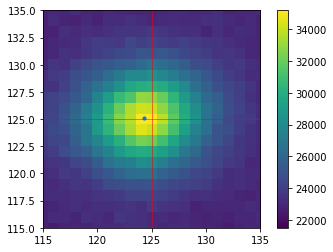

shift in x is  -0.663 ± 0.029  pixels
shift in y is  0.095 ± 0.024 pixels
total shift is 10.050 ± 0.037 nm for pixel size of 15 nm 



(array([124.33677375, 125.09522741]), array([0.02872359, 0.02372995]))

In [2]:
wdir = r'N:\Singlem\singlem19-1\February\21_FRC_NV_CG'
ext = r'Drifts analysis\Red Photons'
filedir = os.path.join(wdir, ext)
img = readfolder(filedir)
plotWindow = 10
imcenter = 125
pixelSize = 15
for i in range (49):
    imA = np.sum(img[i:i+1], axis = 0)
    imB = np.sum(img[i+1:i+2], axis = 0)
    DriftDetect(imA, imB, pixelSize, verbose = False, plotWindow = plotWindow)
    
imA = np.sum(img[0:1], axis = 0)
imB = np.sum(img[49:50], axis = 0)
DriftDetect(imA, imB, pixelSize, verbose = True, plotWindow = plotWindow)

## FRC analysis

In [231]:
theta = 0
meanFilterwidth = 3
pixelSize = 25 #in nm
title = 'someTitle'
fileA = r"K:\vanderVoortN\FRC\python\PQSpcm_2019-02-01_15-59-23-chan0-25\Green Photons\Frames_    0-  199.txt"
fileB = r"K:\vanderVoortN\FRC\python\PQSpcm_2019-02-01_15-59-23-chan25-200\Green Photons\Frames_    0-  199.txt"

imA, imB = readtxt(fileA, fileB)

FRCAnalysis(imA, imB, pixelSize, theta = 0)

OSError: K:\vanderVoortN\FRC\python\PQSpcm_2019-02-01_15-59-23-chan0-25\Green Photons\Frames_    0-  199.txt not found.

applied drift correction of -12.955597 nm in x and and -6.260567 nm in y.



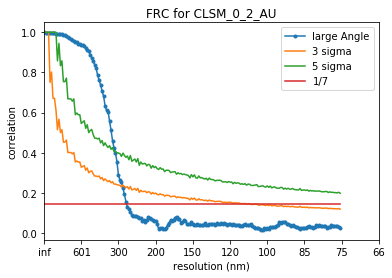

retrieved resolution for CLSM_0_2_AU is: 269nm

total number of photons is:385821
average number of photons per pixel is:2.41138125
for file CLSM02:
 resolution threshold for 1/7, three sigma and five sigma is 
[268.57142857 283.77358491 313.33333333]




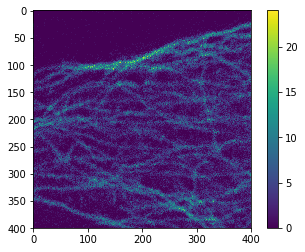

In [2]:
pixelSize = 37.6 #in nm
fileA = r"K:\vanderVoortN\FRC\python\Demo\demoImages\Measure1_CLSM_0_2_AU.raw"
fileB = r"K:\vanderVoortN\FRC\python\Demo\demoImages\Measure2_CLSM_0_2_AU.raw"
title = 'CLSM_0_2_AU'


imA, imB = readraw(fileA, fileB, 400, 400)

__, CLSM02largeAngles, CLSM02threeSigma, CLSM02fiveSigma, __, CLSM02res = FRCAnalysis(
    imA, imB, pixelSize, title = title, correctDrift = True)

plt.imshow(imA)
plt.colorbar()
totalpixels = np.sum (imA)
print("total number of photons is:" + str(totalpixels))
print("average number of photons per pixel is:" + str(totalpixels / (400 * 400)))

print("for file CLSM02:\n " +
     "resolution threshold for 1/7, three sigma and five sigma is \n" + 
     str(CLSM02res[:,0]) + "\n\n")

total number of photons is:385821
average number of photons per pixel is:2.41138125


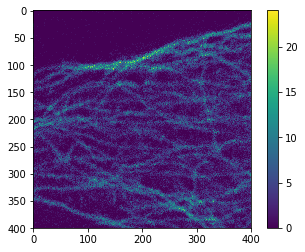

In [13]:
plt.imshow(imA)
plt.colorbar()
totalpixels = np.sum (imA)
print("total number of photons is:" + str(totalpixels))
print("average number of photons per pixel is:" + str(totalpixels / (400 * 400)))